<a href="https://colab.research.google.com/github/rohitvmeshram/Electricity_Demand_and_Price_forecasting/blob/main/Electricity_Demand_and_Price_forecasting_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Electricity Demand and Price forecasting

The focal point of this project revolves around time series forecasting, encompassing the integration of two separate datasets comprising energy and weather data. By amalgamating energy consumption and weather-related metrics from multiple cities in Spain, the project endeavors to tackle a multivariate time series forecasting challenge.



•	The first operational step in the file involves loading two datasets:
o	Energy dataset: This contains information on electricity prices, demand, and generation.
o	Weather dataset: This dataset captures weather conditions like temperature, humidity, wind speed, etc.
•	Data Reading: The data is loaded into the environment using pandas. CSV files are read for both energy and weather data, and a preliminary analysis of their structure is performed using methods like .head() to inspect the first few rows of the data.


# **1. Cleaning energy :**

•	Handling Missing Values: Often, datasets contain missing or incomplete information. Filling in missing values or removing rows/columns with too much missing data is critical for making the data suitable for model training.
o	Techniques like interpolation or forward fill may have been used to handle time series gaps.
•	Merging Datasets: Since two different datasets (energy and weather) are being used, they need to be merged into a single dataset using a common key, likely the date and time. This ensures that for each energy consumption record, the corresponding weather data is available for that same time period.
•	Feature Selection: This step involves selecting the relevant features from both datasets for the model. Features might include:
o	From the energy dataset: electricity prices, energy demand, energy generation.
o	From the weather dataset: temperature, humidity, wind speed, etc.


In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf



from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [ ]:
# loading energy data
df_energy = pd.read_csv('/content/energy_dataset.csv')

In [ ]:
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

<li>Apparantly most stats for some features are constituted to be 0 or Nan. we will remove those columns.
We will also remove day ahead forecasting columns.</li>

In [ ]:
df_energy.describe().T

count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

In [ ]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [ ]:
# columns to be removed due to all 0 or Nan values
col_names = ['generation fossil coal-derived gas', 'generation fossil oil shale','generation fossil peat',
           'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine',
           'generation wind offshore', 'forecast wind offshore eday ahead', 'forecast solar day ahead',
            'forecast wind onshore day ahead']

In [ ]:
df_energy = df_energy.drop(col_names, axis = 1)

In [ ]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):

    print('Number of Nans in each column :')

    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [ ]:
check_Nans_Dups(df_energy)

Number of Nans in each column :
time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Numb

In [ ]:
df_energy['time'] = pd.to_datetime(df_energy['time'])
df_energy = df_energy.set_index('time')
df_energy

<ipython-input-11-c0cd3855ec4e>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_energy['time'] = pd.to_datetime(df_energy['time'])


generation biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   
...                                                         ...   
2018-12-31 19:00:00+01:00                                   0.0   
2018-12-31 20:00:00+01:00                                   0.0   
2018-12-31 21:00:00+01:00                                   0.0   
2018-12-31 22:00:00+01:00                                   0.0   
2018-12-31 23:00:00+01:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 19:00:00+01:00                 7634.0                       2628.0   
2018-12-31 20:00:00+01:00                 7241.0                       2566.0   
2018-12-31 21:00:00+01:00                 7025.0                       2422.0   
2018-12-31 22:00:00+01:00                 6562.0                       2293.0   
2018-12-31 23:00:00+01:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2018-12-31 19:00:00+01:00                  178.0   
2018-12-31 20:00:00+01:00                  174.0   
2018-12-31 21:00:00+01:00                  168.0   
2018-12-31 22:00:00+01:00                  163.0   
2018-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2018-12-31 19:00:00+01:00                                          1.0   
2018-12-31 20:00:00+01:00                                          1.0   
2018-12-31 21:00:00+01:00                     

Text(0, 0.5, 'total load actual')

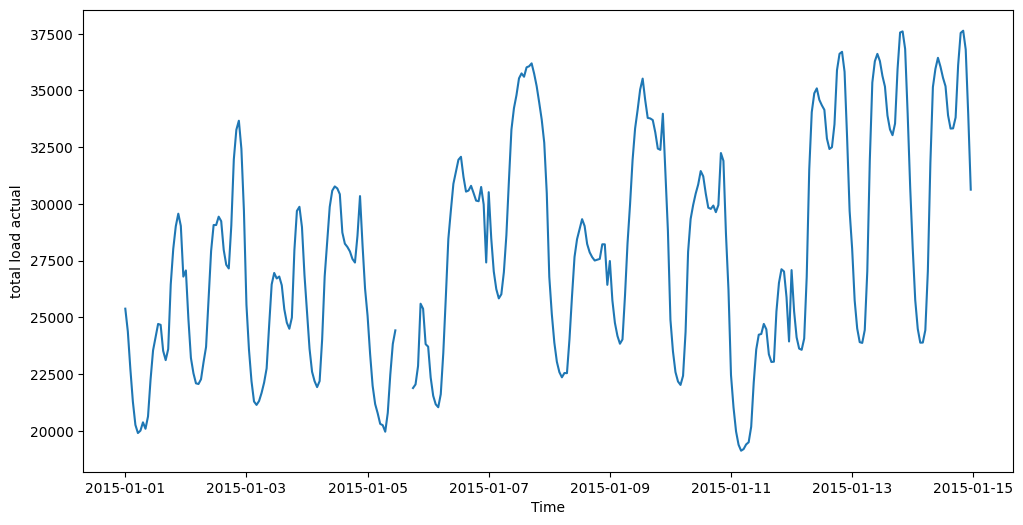

In [ ]:
plt.figure(figsize=(12,6))
# plot total load actual for two weeks duration
plt.plot(df_energy['total load actual'][:24*7*2])
plt.xlabel('Time')
plt.ylabel('total load actual')

<li> So, it seems there are not too many Nan values in dataframe.In general, if the number of missing values
is relatively small and the time series has a regular frequency, interpolation methods such as linear or
spline interpolation can be used to estimate the missing values. On the other hand, if the number of
missing values is large or if the missing values are irregularly spaced, it may be better to remove
them, as interpolating over large gaps can introduce noise and bias in the data. So we will linearly
interploate the nan values. </li>

In [ ]:
df_energy[df_energy.isna().any(axis = 1)]

generation biomass  \
time                                            
2015-01-05 03:00:00+01:00                 NaN   
2015-01-05 12:00:00+01:00                 NaN   
2015-01-05 13:00:00+01:00                 NaN   
2015-01-05 14:00:00+01:00                 NaN   
2015-01-05 15:00:00+01:00                 NaN   
2015-01-05 16:00:00+01:00                 NaN   
2015-01-05 17:00:00+01:00                 NaN   
2015-01-19 19:00:00+01:00                 NaN   
2015-01-19 20:00:00+01:00                 NaN   
2015-01-27 19:00:00+01:00                 NaN   
2015-01-28 13:00:00+01:00                 NaN   
2015-02-01 07:00:00+01:00               449.0   
2015-02-01 08:00:00+01:00               453.0   
2015-02-01 09:00:00+01:00               452.0   
2015-02-01 12:00:00+01:00               405.0   
2015-02-01 13:00:00+01:00               402.0   
2015-02-01 14:00:00+01:00               400.0   
2015-02-01 15:00:00+01:00               393.0   
2015-02-01 16:00:00+01:00               413.0   
2015-02-01 17:00:00+01:00               465.0   
2015-02-01 18:00:00+01:00               482.0   
2015-02-01 19:00:00+01:00               474.0   
2015-04-05 03:00:00+02:00               371.0   
2015-04-16 09:00:00+02:00                 NaN   
2015-04-20 08:00:00+02:00               424.0   
2015-04-23 21:00:00+02:00                 NaN   
2015-05-02 10:00:00+02:00               497.0   
2015-05-29 03:00:00+02:00               569.0   
2015-06-15 09:00:00+02:00                 NaN   
2015-10-02 08:00:00+02:00               483.0   
2015-10-02 11:00:00+02:00                 NaN   
2015-12-02 09:00:00+01:00                 NaN   
2016-04-13 05:00:00+02:00               220.0   
2016-04-25 05:00:00+02:00               190.0   
2016-04-25 07:00:00+02:00               206.0   
2016-05-10 23:00:00+02:00               348.0   
2016-06-12 01:00:00+02:00               356.0   
2016-07-09 22:00:00+02:00                 NaN   
2016-07-12 00:00:00+02:00               346.0   
2016-09-28 09:00:00+02:00               347.0   
2016-10-27 23:00:00+02:00               351.0   
2016-11-23 04:00:00+01:00                 NaN   
2017-11-14 12:00:00+01:00                 0.0   
2017-11-14 19:00:00+01:00                 0.0   
2018-06-11 18:00:00+02:00               331.0   
2018-07-11 09:00:00+02:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 03:00:00+01:00                                   NaN   
2015-01-05 12:00:00+01:00                                   NaN   
2015-01-05 13:00:00+01:00                                   NaN   
2015-01-05 14:00:00+01:00                                   NaN   
2015-01-05 15:00:00+01:00                                   NaN   
2015-01-05 16:00:00+01:00                                   NaN   
2015-01-05 17:00:00+01:00                                   NaN   
2015-01-19 19:00:00+01:00                                   NaN   
2015-01-19 20:00:00+01:00                                   NaN   
2015-01-27 19:00:00+01:00                                   NaN   
2015-01-28 13:00:00+01:00                                   NaN   
2015-02-01 07:00:00+01:00                                 312.0   
2015-02-01 08:00:00+01:00                                 312.0   
2015-02-01 09:00:00+01:00                                 302.0   
2015-02-01 12:00:00+01:00                                 317.0   
2015-02-01 13:00:00+01:00                                 317.0   
2015-02-01 14:00:00+01:00                                 317.0   
2015-02-01 15:00:00+01:00                                 321.0   
2015-02-01 16:00:00+01:00                                 325.0   
2015-02-01 17:00:00+01:00                                 321.0   
2015-02-01 18:00:00+01:00                                 326.0   
2015-02-01 19:00:00+01:00                                 326.0   
2015-04-05 03:00:00+02:00                                   0.0   

In [ ]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace = True)

<li> So, there is no any NaN value in the data! </li>

In [ ]:
df_energy.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

# Feature Correlation

<strong> Feature Correlation </strong>

<li> Based on the feaure correlation,  There is a strong correlation between <strong>"generation fossil hard coal"</strong> and <strong>"generation fossil brown coal/lignite"</strong>. So with a common sense we can combine these two feature as a
<strong>"generation fossil total"</strong> and remove them. </li>

<strong> Note : </strong> There is a very high correlation between <strong>Total load forecasting</strong> and <strong>total load actual.</strong> For now,
I will keep this for visulization part of this project but before feeding the data into model I will drop this column.

In [ ]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')

    return plt.show()

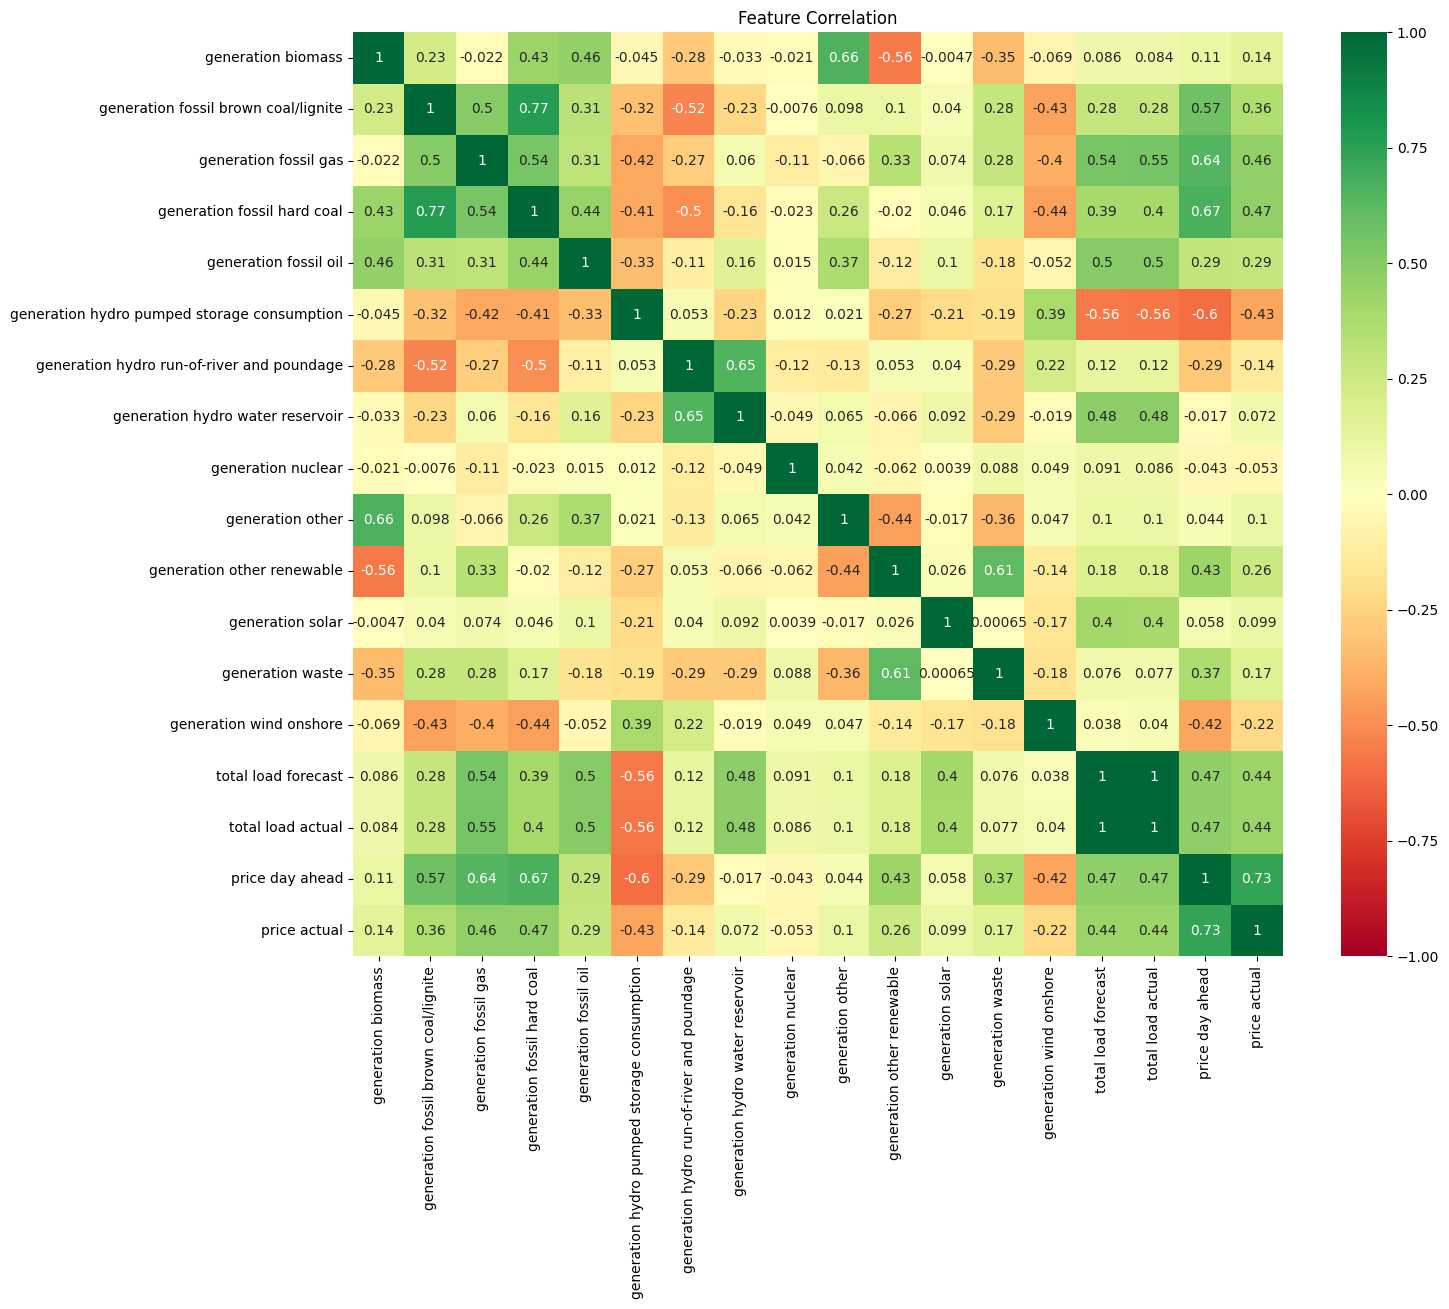

In [ ]:
feat_corr(df_energy)

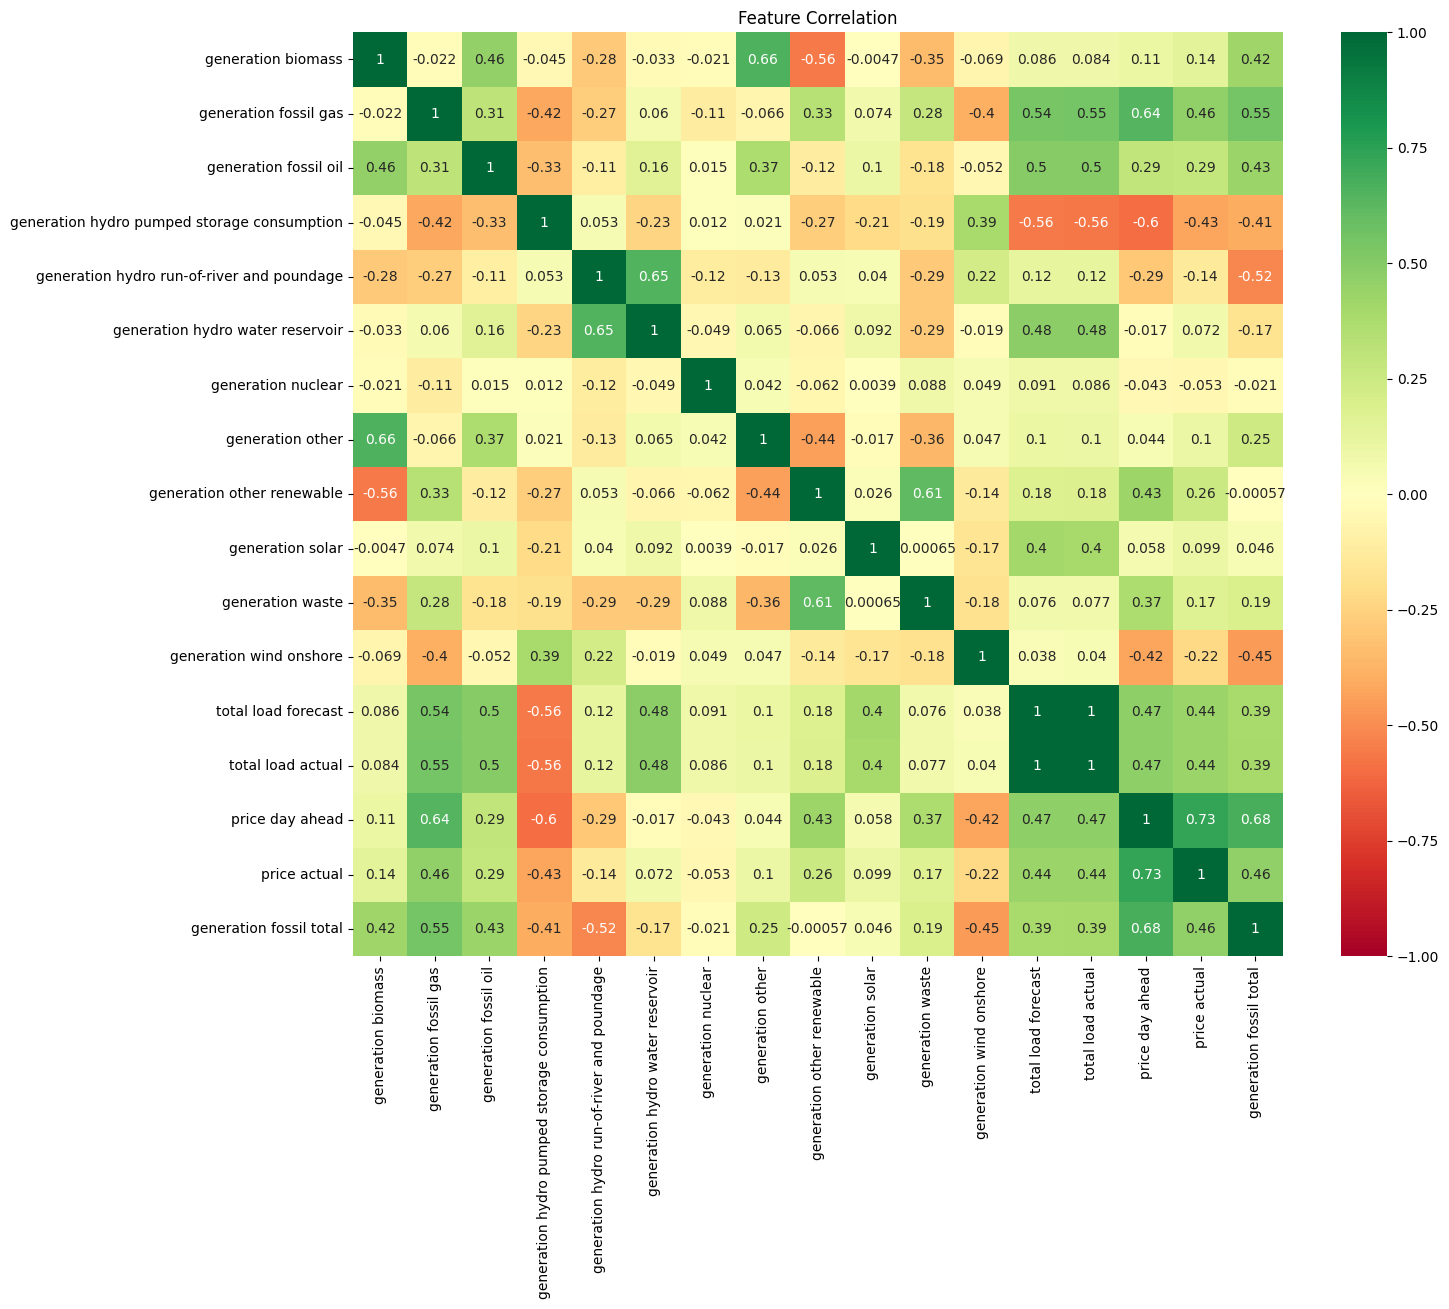

In [ ]:
df_energy["generation fossil total"] = df_energy['generation fossil hard coal'] + df_energy['generation fossil brown coal/lignite']
df_energy.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1, inplace = True)
feat_corr(df_energy)

# **2. Cleaning weather :**

•	Handling Missing Values: Often, datasets contain missing or incomplete information. Filling in missing values or removing rows/columns with too much missing data is critical for making the data suitable for model training.
o	Techniques like interpolation or forward fill may have been used to handle time series gaps.
•	Merging Datasets: Since two different datasets (energy and weather) are being used, they need to be merged into a single dataset using a common key, likely the date and time. This ensures that for each energy consumption record, the corresponding weather data is available for that same time period.
•	Feature Selection: This step involves selecting the relevant features from both datasets for the model. Features might include:
o	From the energy dataset: electricity prices, energy demand, energy generation.
o	From the weather dataset: temperature, humidity, wind speed, etc.


<h3> Weather dataset </h3>

In [ ]:
# Loading weather data
df_weather = pd.read_csv('/content/weather_features.csv')

In [ ]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

<li> Based on a quick look at the dataframe we will notice that <strong>'weather_icon'</strong> seems useless feature.
Beside that colud cover that is reflected in <strong>'weather_main' and 'weather_description'</strong> can afftect the prediction, but since
this is hourly requirements and since their effect is reflected in measured temprerature, we can drop these two columns as well and instead
we can keep <strong>'clouds_all'</strong>. But before deciding on which feature to drop, lets see the feature correlations.</li>

In [ ]:
df_temp = df_weather.copy(deep = True)
labels = ['weather_id', 'weather_main','weather_description','weather_icon']
for col in labels:
    df_temp[col] = LabelEncoder().fit_transform(df_weather[col])

<p>
</p>
<li> Apparantly there is strong correlation between the features that we talked about. Having strong correlation between
features might cuase multicolinearity. So, we can drop <strong>'weather_icon', 'weather_main', 'weather_description', and 'weather_id'</strong>
and just keep <strong>'clouds_all'</strong>. There is also a very strong correlation between 'temp', 'temp_min' and 'temp_max'. So we drop temp_max
and temp_min and just keep <strong> 'temp'</strong>.</li>

In [ ]:
df_weather['weather_id'].unique()

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [ ]:
col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon', 'temp_min', 'temp_max']
# col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [ ]:
check_Nans_Dups(df_weather)

Number of Nans in each column :
dt_iso        0
city_name     0
temp          0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
dtype: int64

Number of duplicates in the dataframe : 3076


In [ ]:
df_weather = df_weather.reset_index().drop_duplicates()

In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])
df_weather.drop(["dt_iso"] , axis = 1, inplace = True)
df_weather = df_weather.set_index('time')
df_weather.drop(["index"] , axis = 1, inplace = True)

<ipython-input-51-f2d592ef1b17>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])


In [ ]:
df_weather

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2015-01-01 00:00:00+01:00  Valencia  270.475      1001        77           1   
2015-01-01 01:00:00+01:00  Valencia  270.475      1001        77           1   
2015-01-01 02:00:00+01:00  Valencia  269.686      1002        78           0   
2015-01-01 03:00:00+01:00  Valencia  269.686      1002        78           0   
2015-01-01 04:00:00+01:00  Valencia  269.686      1002        78           0   
...                             ...      ...       ...       ...         ...   
2018-12-31 19:00:00+01:00   Seville  287.760      1028        54           3   
2018-12-31 20:00:00+01:00   Seville  285.760      1029        62           3   
2018-12-31 21:00:00+01:00   Seville  285.150      1028        58           4   
2018-12-31 22:00:00+01:00   Seville  284.150      1029        57           4   
2018-12-31 23:00:00+01:00   Seville  283.970      1029        70           3   

                           wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  
time                                                                        
2015-01-01 00:00:00+01:00        62      0.0      0.0      0.0           0  
2015-01-01 01:00:00+01:00        62      0.0      0.0      0.0           0  
2015-01-01 02:00:00+01:00        23      0.0      0.0      0.0           0  
2015-01-01 03:00:00+01:00        23      0.0      0.0      0.0           0  
2015-01-01 04:00:00+01:00        23      0.0      0.0      0.0           0  
...                             ...      ...      ...      ...         ...  
2018-12-31 19:00:00+01:00        30      0.0      0.0      0.0           0  
2018-12-31 20:00:00+01:00        30      0.0      0.0      0.0           0  
2018-12-31 21:00:00+01:00        50      0.0      0.0      0.0           0  
2018-12-31 22:00:00+01:00        60      0.0      0.0      0.0           0  
2018-12-31 23:00:00+01:00        50      0.0      0.0      0.0           0  

[178396 rows x 10 columns]

In [ ]:
df_energy

generation biomass  generation fossil gas  \
time                                                                   
2015-01-01 00:00:00+01:00               447.0                 4844.0   
2015-01-01 01:00:00+01:00               449.0                 5196.0   
2015-01-01 02:00:00+01:00               448.0                 4857.0   
2015-01-01 03:00:00+01:00               438.0                 4314.0   
2015-01-01 04:00:00+01:00               428.0                 4130.0   
...                                       ...                    ...   
2018-12-31 19:00:00+01:00               297.0                 7634.0   
2018-12-31 20:00:00+01:00               296.0                 7241.0   
2018-12-31 21:00:00+01:00               292.0                 7025.0   
2018-12-31 22:00:00+01:00               293.0                 6562.0   
2018-12-31 23:00:00+01:00               290.0                 6926.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2018-12-31 19:00:00+01:00                  178.0   
2018-12-31 20:00:00+01:00                  174.0   
2018-12-31 21:00:00+01:00                  168.0   
2018-12-31 22:00:00+01:00                  163.0   
2018-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2018-12-31 19:00:00+01:00                                          1.0   
2018-12-31 20:00:00+01:00                                          1.0   
2018-12-31 21:00:00+01:00                                         50.0   
2018-12-31 22:00:00+01:00                                        108.0   
2018-12-31 23:00:00+01:00                                        108.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2015-01-01 00:00:00+01:00                                      1051.0   
2015-01-01 01:00:00+01:00                                      1009.0   
2015-01-01 02:00:00+01:00                                       973.0   
2015-01-01 03:00:00+01:00                                       949.0   
2015-01-01 04:00:00+01:00                                       953.0   
...                                                               ...   
2018-12-31 19:00:00+01:00                                      1135.0   
2018-12-31 20:00:00+01:00                                      1172.0   
2018-12-31 21:00:00+01:00                                      1148.0   
2018-12-31 22:00:00+01:00                                      1128.0   
2018-12-31 23:00:00+01:00                                      1069.0   

                           generation hydro water reservoir  \
time                                                          
2015-01-01 00:00:00+01:00                            1899.0   
2015-01-01 01:00:00+01:00                            1658.0   
2015-01-01 02:00:00+01:00                            1371.0   
2015-01-01 03:00:00+01:00                             779.0   
2015-01-01 04:00:00+01:00                             720.0   
...                                                     ...

<li> Based on stats below, we can see that there are some outliers in pressure, wind_speed and maybe rain_1h and rain_3h.
So we can see outliers in the plots. we will remove pressure and wind_speed outlier and also drop rain_3h. Becuase
rain_3h is supposed to be the amount of percipitation in the last 3 hr which should be higher than rain_1h, but the plot
does not confirm this. So we drop rain_3h. </li>

In [ ]:
df_weather.describe().round(2)

temp    pressure   humidity  wind_speed   wind_deg    rain_1h  \
count  178396.00   178396.00  178396.00   178396.00  178396.00  178396.00   
mean      289.62     1069.26      68.42        2.47     166.59       0.08   
std         8.03     5969.63      21.90        2.10     116.61       0.40   
min       262.24        0.00       0.00        0.00       0.00       0.00   
25%       283.67     1013.00      53.00        1.00      55.00       0.00   
50%       289.15     1018.00      72.00        2.00     177.00       0.00   
75%       295.15     1022.00      87.00        4.00     270.00       0.00   
max       315.60  1008371.00     100.00      133.00     360.00      12.00   

         rain_3h    snow_3h  clouds_all  
count  178396.00  178396.00   178396.00  
mean        0.00       0.00       25.07  
std         0.01       0.22       30.77  
min         0.00       0.00        0.00  
25%         0.00       0.00        0.00  
50%         0.00       0.00       20.00  
75%         0.00       0.00       40.00  
max         2.32      21.50      100.00

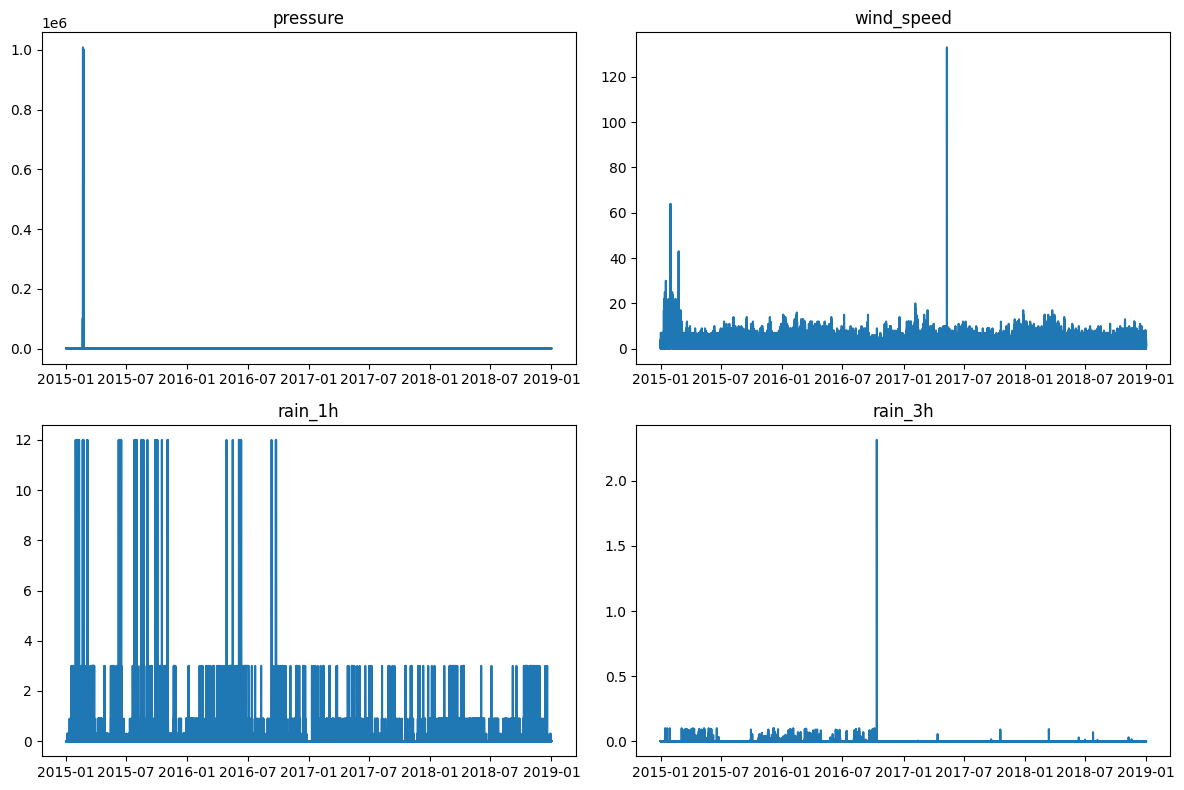

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.plot(df_weather.index, df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

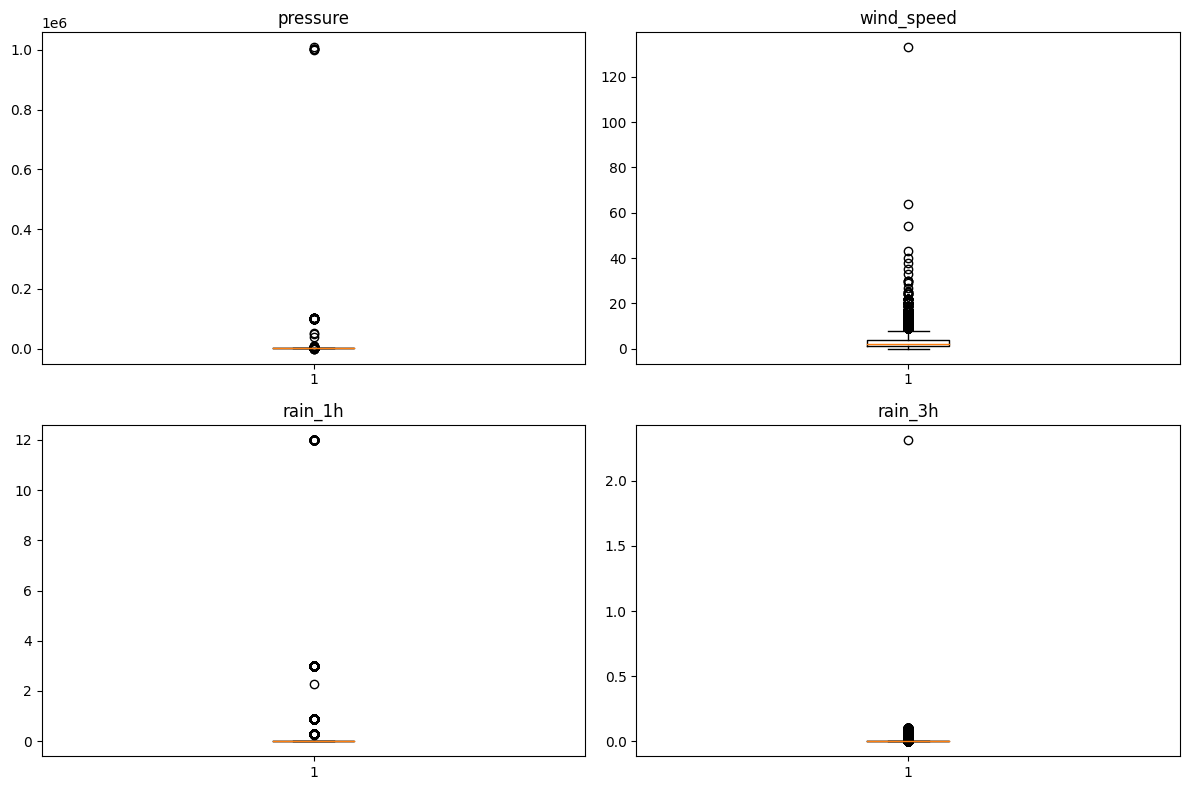

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

 So we set the max threshold as these numbers and replace the outliers with Nan values and then use interpolation to fill the gap. </li>        

In [ ]:
df_weather.loc[df_weather['pressure']  > 1080,  'pressure'] = np.nan
df_weather.loc[df_weather['pressure']   < 870,  'pressure'] = np.nan
df_weather.loc[df_weather['wind_speed'] > 113, 'wind_speed'] = np.nan

df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)

<ipython-input-57-e09d3d1c477d>:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)


<li> Check if the outliers are removed! </li>

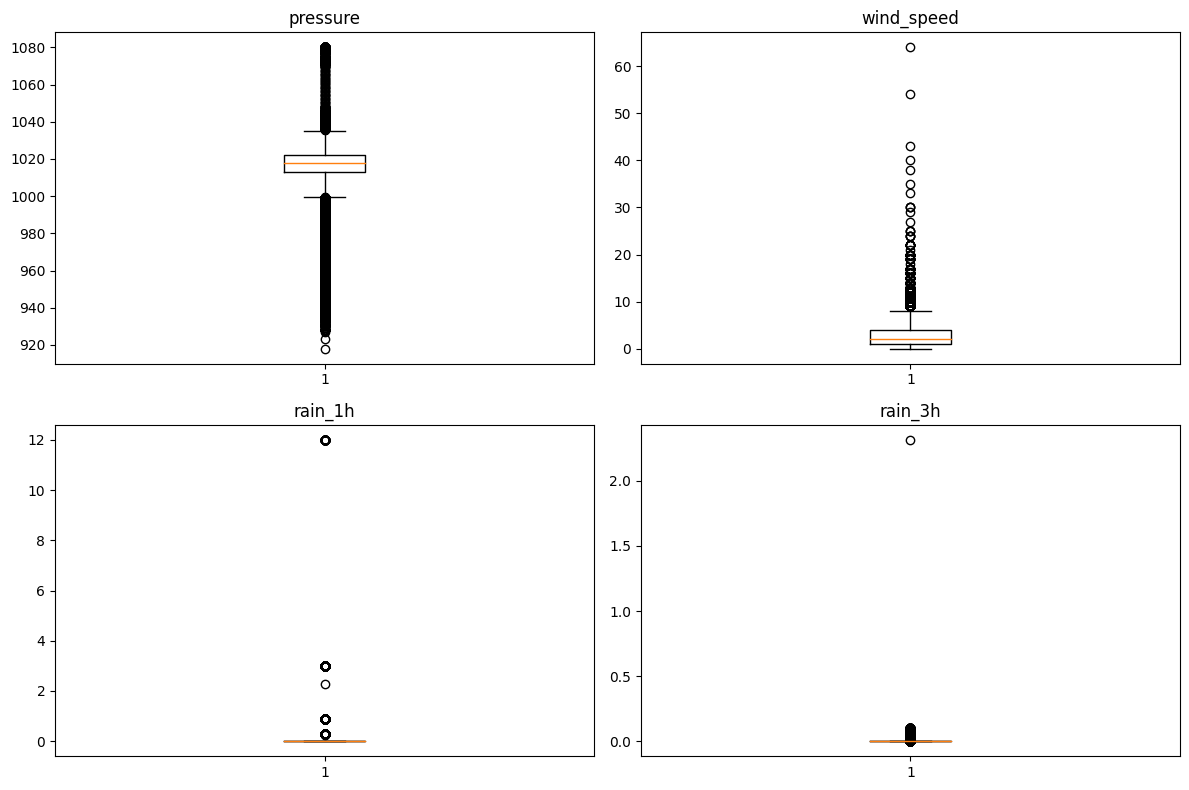

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

In [ ]:
# be sure to drop rain_h3
df_weather.drop(['rain_3h'], axis = 1 , inplace = True)

<li> So number of samples in each group of city is not consistent! probably it has duplicates!</li>

In [ ]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35145
Number of samples in df_weather in Madrid is 36267
Number of samples in df_weather in Bilbao is 35951
Number of samples in df_weather in  Barcelona is 35476
Number of samples in df_weather in Seville is 35557


In [ ]:
df_weather_cleaned = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [ ]:
df_weather_cleaned

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2015-01-01 00:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2015-01-01 01:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2015-01-01 02:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2015-01-01 03:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2015-01-01 04:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
...                             ...      ...       ...       ...         ...   
2018-12-31 19:00:00+01:00   Seville  287.760    1028.0        54         3.0   
2018-12-31 20:00:00+01:00   Seville  285.760    1029.0        62         3.0   
2018-12-31 21:00:00+01:00   Seville  285.150    1028.0        58         4.0   
2018-12-31 22:00:00+01:00   Seville  284.150    1029.0        57         4.0   
2018-12-31 23:00:00+01:00   Seville  283.970    1029.0        70         3.0   

                           wind_deg  rain_1h  snow_3h  clouds_all  
time                                                               
2015-01-01 00:00:00+01:00        62      0.0      0.0           0  
2015-01-01 01:00:00+01:00        62      0.0      0.0           0  
2015-01-01 02:00:00+01:00        23      0.0      0.0           0  
2015-01-01 03:00:00+01:00        23      0.0      0.0           0  
2015-01-01 04:00:00+01:00        23      0.0      0.0           0  
...                             ...      ...      ...         ...  
2018-12-31 19:00:00+01:00        30      0.0      0.0           0  
2018-12-31 20:00:00+01:00        30      0.0      0.0           0  
2018-12-31 21:00:00+01:00        50      0.0      0.0           0  
2018-12-31 22:00:00+01:00        60      0.0      0.0           0  
2018-12-31 23:00:00+01:00        50      0.0      0.0           0  

[175320 rows x 9 columns]

<li> Now the number of samples in each group is the same! So we can concat weather dataframe with energy dataframe.</li>

In [ ]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather_cleaned.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35064
Number of samples in df_weather in Madrid is 35064
Number of samples in df_weather in Bilbao is 35064
Number of samples in df_weather in  Barcelona is 35064
Number of samples in df_weather in Seville is 35064


In [ ]:
df_weather_all_cities = [grouped_weather.get_group(x) for x in grouped_weather.groups]

In [ ]:
df_weather_all_cities[0]

city_name     temp  pressure  humidity  \
time                                                                 
2015-01-01 00:00:00+01:00   Barcelona  281.625    1035.0       100   
2015-01-01 01:00:00+01:00   Barcelona  281.625    1035.0       100   
2015-01-01 02:00:00+01:00   Barcelona  281.286    1036.0       100   
2015-01-01 03:00:00+01:00   Barcelona  281.286    1036.0       100   
2015-01-01 04:00:00+01:00   Barcelona  281.286    1036.0       100   
...                               ...      ...       ...       ...   
2018-12-31 19:00:00+01:00   Barcelona  284.130    1027.0        71   
2018-12-31 20:00:00+01:00   Barcelona  282.640    1027.0        62   
2018-12-31 21:00:00+01:00   Barcelona  282.140    1028.0        53   
2018-12-31 22:00:00+01:00   Barcelona  281.130    1028.0        50   
2018-12-31 23:00:00+01:00   Barcelona  280.130    1028.0       100   

                           wind_speed  wind_deg  rain_1h  snow_3h  clouds_all  
time                                                                           
2015-01-01 00:00:00+01:00         7.0        58      0.0      0.0           0  
2015-01-01 01:00:00+01:00         7.0        58      0.0      0.0           0  
2015-01-01 02:00:00+01:00         7.0        48      0.0      0.0           0  
2015-01-01 03:00:00+01:00         7.0        48      0.0      0.0           0  
2015-01-01 04:00:00+01:00         7.0        48      0.0      0.0           0  
...                               ...       ...      ...      ...         ...  
2018-12-31 19:00:00+01:00         1.0       250      0.0      0.0           0  
2018-12-31 20:00:00+01:00         3.0       270      0.0      0.0           0  
2018-12-31 21:00:00+01:00         4.0       300      0.0      0.0           0  
2018-12-31 22:00:00+01:00         5.0       320      0.0      0.0           0  
2018-12-31 23:00:00+01:00         5.0       310      0.0      0.0           0  

[35064 rows x 9 columns]

# **3. Data Merging :**

In [ ]:
df_weather_energy = df_energy

for df_city in df_weather_all_cities:
    city_name = df_city.iloc[0]['city_name'].replace(' ', '')
    df_temp_city = df_city.add_suffix(f'_{city_name}')
    df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1)
    df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}' , axis=1)

In [ ]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

<li> So far, so good! There is no duplicates and Nans in df_weather_energy! </li>

In [ ]:
check_Nans_Dups(df_weather_energy)

Number of Nans in each column :
generation biomass                             0
generation fossil gas                          0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
generation fossil total                        0
temp_Barcelona                                 0
pressure_Barcelona                             0
humidity_Barcelona                   

<li>There are some powerful feature engineering techniques for time series that can boost the model perfroamnce:

<a href="https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/">https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/</a>
<p>
</p>
<li> For now, we are adding <strong>hour, weekday and month</strong> features to dataframe. These information can be helpful. For example in
shoulder seasons the heating and cooling load of all residential and commercial buildings will be low compared to summer/winter. or at the
weekend, since the office buildings are closed, the energy consumption will be lower.Regading the time, defintily energy consumption at 3 am
is way lower than the energy consumption at 10 am. So these features can be very helpful in building a good model.</li>
<p>
</p>

In [ ]:
df_weather_energy['hour'] = df_weather_energy.index.map(lambda x : x.hour)
df_weather_energy['weekday'] = df_weather_energy.index.map(lambda x : x.weekday())
df_weather_energy['month'] = df_weather_energy.index.map(lambda x : x.month)
df_weather_energy['year'] = df_weather_energy.index.map(lambda x: x.year)

In [ ]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

# **4.  Visualisation :**

•	Visualizations: The project likely employs visual tools such as:
o	Line plots to observe trends in electricity prices and demand over time.
o	Scatter plots or heatmaps to analyze the relationships between different variables (e.g., temperature vs. demand, humidity vs. price).
o	Distribution plots to understand the spread of the data and check for skewness.
•	Trend Analysis: Identifying long-term trends, seasonality, or cyclic behaviors in the energy demand data, which is important for effective time series forecasting.
•	Correlation Analysis: Understanding which weather factors (e.g., temperature, humidity) are most strongly correlated with changes in electricity demand and price.


In [ ]:
fig = make_subplots()

fig.add_trace(
    go.Line(x=df_weather_energy.index, y=df_weather_energy["price actual"],
                                name="price actual"))
fig.add_trace(
    go.Line(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24).mean()["price actual"],
                                        name="rolling window = daily ave"))
fig.add_trace(
    go.Line(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24*7).mean()["price actual"],
                                        name="rolling window = weekly ave"))
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<li> Based on the month bar plot, the actual price in Jan and Dec is high and on weekly daily basis,
we witness the lowest price at weekends. </li>

Text(0.5, 1.0, 'Daily actual price (0 is Monday)')

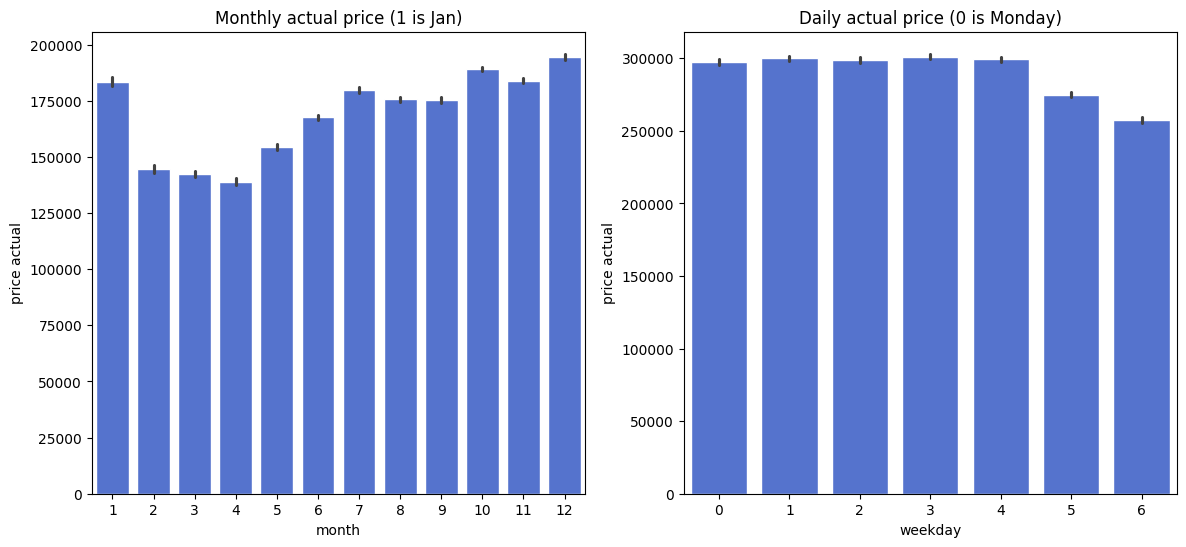

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

sns.barplot(
    x="month",
    y="price actual",
    data=df_weather_energy,
    estimator=sum,
    color='royalblue',
    ax=axes[0]);
axes[0].set_title('Monthly actual price (1 is Jan)')

sns.barplot(
    x="weekday",
    y="price actual",
    data=df_weather_energy,
    estimator=sum,
    color='royalblue',
    ax=axes[1]);
axes[1].set_title('Daily actual price (0 is Monday)')


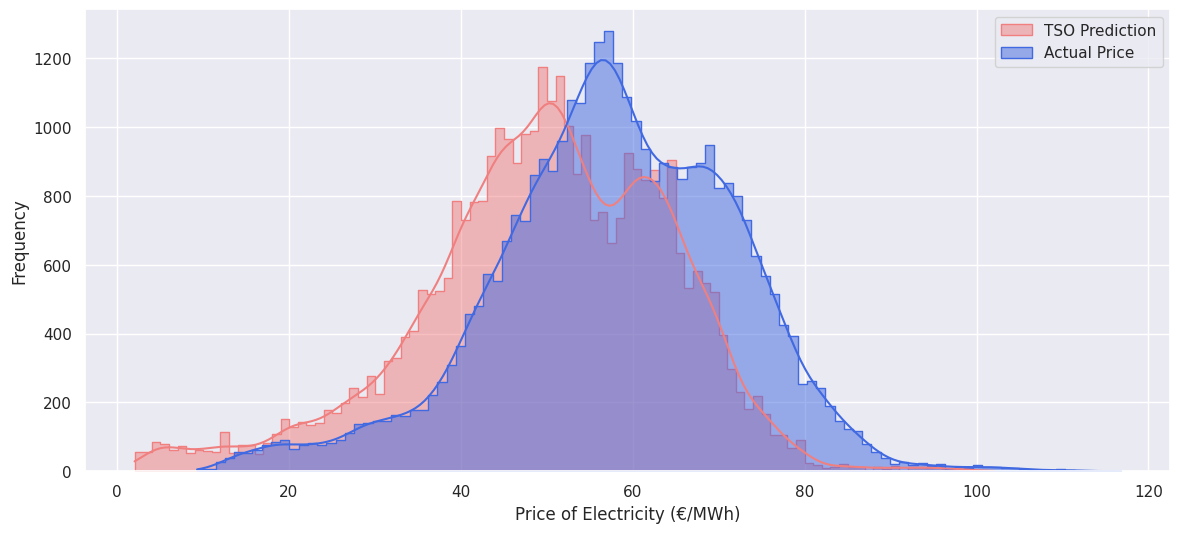

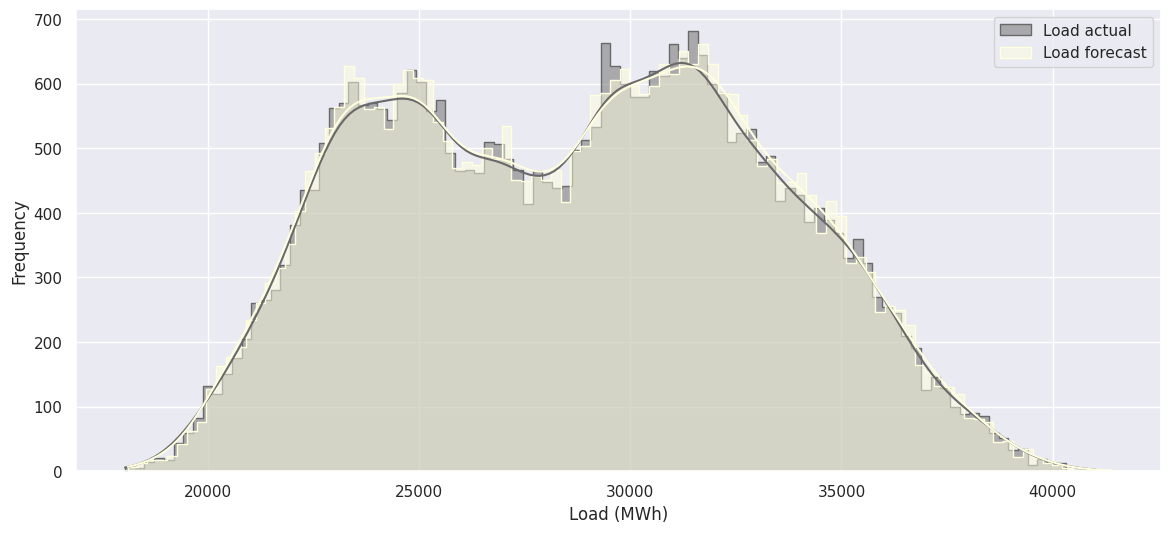

In [ ]:
plt.figure(figsize=(14,6))

gr = sns.histplot(df_weather_energy['price day ahead'], bins=100, label='TSO Prediction', element="step", color='lightcoral', kde = True)
gr = sns.histplot(df_weather_energy['price actual'], bins=100, label='Actual Price', element="step", color='royalblue', kde = True)


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
gr = sns.histplot(df_weather_energy['total load actual'], bins=100, label='Load actual', element="step", color='dimgrey', kde = True)
gr = sns.histplot(df_weather_energy['total load forecast'], bins=100, label='Load forecast', element="step", color='lightyellow', kde = True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.legend()
plt.show()

In [ ]:
df_weather_energy.drop(['total load forecast'], axis = 1, inplace = True)

<li> So I decompose the price actual into trend, seasonality and residual(noise). for better visualization,
I ploted 100 first observed seasonality and call it as zoomed seasonality.</li>

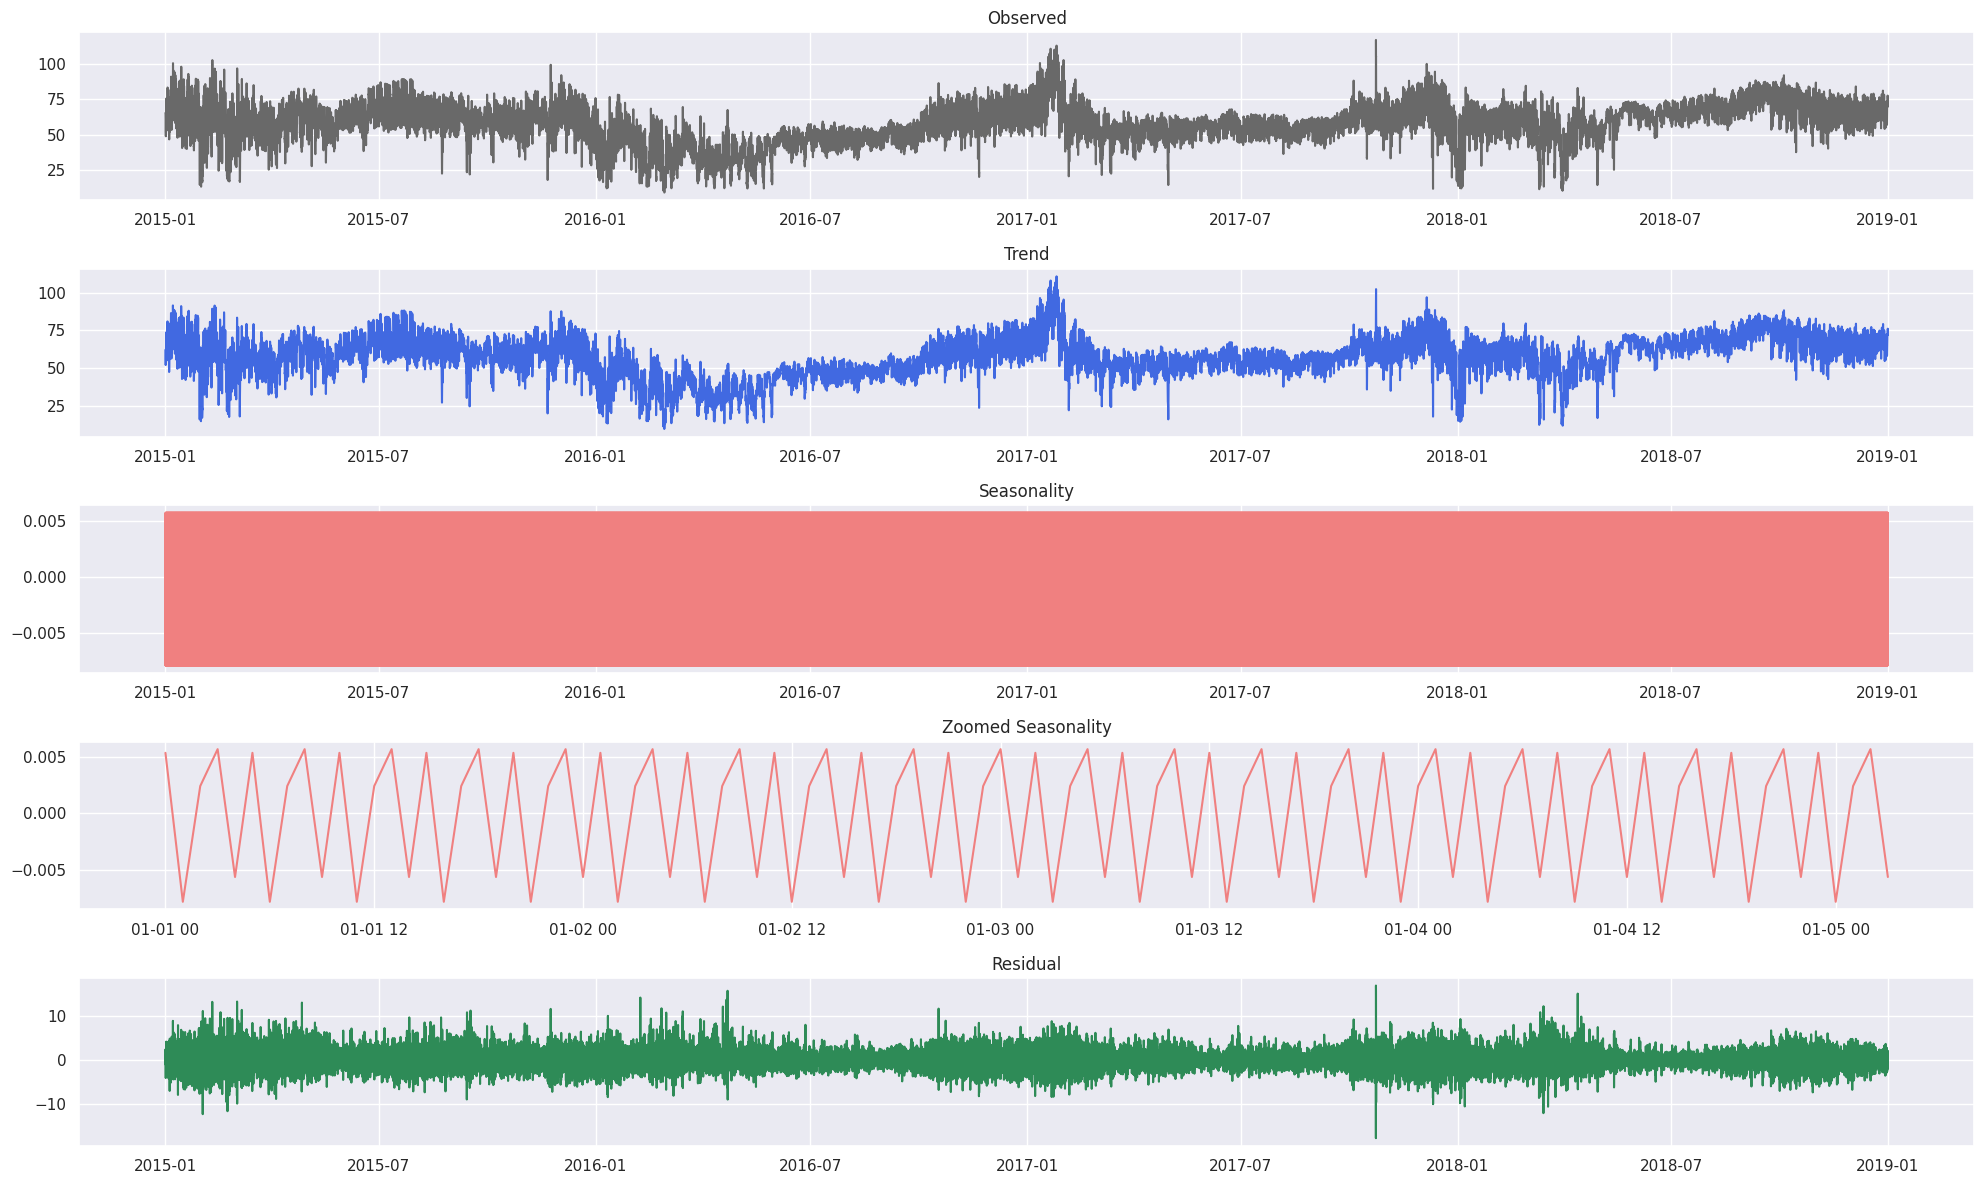

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_weather_energy[['price actual']].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()


# **5.Time Series Analysis :**

<li> <strong> The Dickey-Fuller test </strong>, also known as the Augmented Dickey-Fuller (ADF) test, is a statistical test used to
determine whether a time series is <strong> stationary </strong> or not. Stationarity is an important concept in time series analysis
because it affects the ability to model and predict future values. The test uses a null hypothesis that the time
series has a unit root, meaning that it is non-stationary. The alternative hypothesis is that the time series
is stationary. The test statistic is compared to critical values from tables or computed via a statistical
software package. If the test statistic is less than the critical value, the null hypothesis is rejected,
and it is concluded that the time series is stationary.</li>
<p>
</p>
<li> In the context of time series analysis, stationarity refers to a property of a time series where the
statistical properties of the series <strong> do not change over time </strong>. More specifically, a stationary time series is
one where <strong> the mean, variance, and autocorrelation </strong> structure of the series do not depend on the time at which
they are computed.</li>
<p>
</p>
<li>The concept of stationarity is important in time series analysis because it simplifies the modeling process and
enables the use of statistical tools that assume stationarity, such as  <strong>ARMA</strong> (autoregressive moving average) models.
In contrast, non-stationary time series can exhibit trends, seasonality, and other systematic patterns that can
make it difficult to model and forecast accurately.</li>


In [ ]:
result = adfuller(df_weather_energy[['price actual']])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -9.147016232851248
p-value: 2.750493484933306e-15
Critical Values: {'1%': -3.4305367814665044, '5%': -2.8616225527935106, '10%': -2.566813940257257}


<li> So based on the comments above we can see that the ADF statistics is even lower than the p value with 1%
significance level. So the time series is considered as stationary! </li>

<li> <strong>Autocorrelation</strong> is a measure of the linear dependence between a time series and its lagged values. It measures
how strongly the values of a time series at one time are correlated with the values at other times. Autocorrelation
can be positive (indicating that high values tend to be followed by high values and low values tend to be followed
by low values) or negative (indicating that high values tend to be followed by low values and vice versa). </li>
<p>
</p>
<li> <strong>Partial autocorrelation</strong>, on the other hand, measures the linear dependence between a time series and its lagged
values, <strong> after removing the effect of any intermediate lags </strong>. It provides a measure of the direct correlation between
two time points, taking into account any indirect correlation through intermediate time points. Partial autocorrelation
can help identify the <strong> order </strong> of an autoregressive (AR) model, which is a model that uses lagged values of the time series
as predictors. </li>

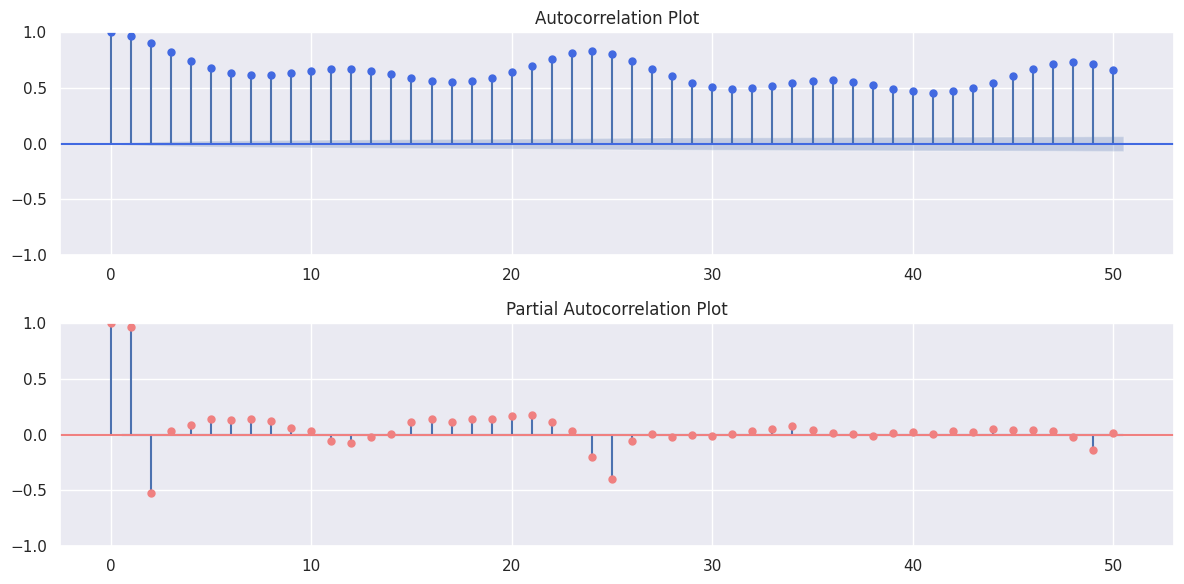

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_weather_energy['price actual'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df_weather_energy['price actual'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

<li> Based on the partial autocorrolation, we have strong correlation of an observation with its past 25 values (after 25,
the correlation becomes very weak). So we use <strong> 25 </strong> lag feature for our time series! </li>

# **6. MODELS**

•	The project explores multiple models for predicting electricity prices and demand. These models are evaluated based on their ability to capture the underlying patterns in the data:
1.	Linear Regression:
o	This model attempts to establish a linear relationship between the dependent variable (e.g., electricity price) and independent variables (e.g., weather conditions).
o	In this case, the model performed poorly because electricity demand and price are influenced by complex, non-linear factors which the linear model fails to capture.
2.	CATBoost:
o	CATBoost is a machine learning algorithm based on gradient boosting and is particularly good at handling categorical data and complex relationships. In this project, CATBoost performed significantly better than Linear Regression, as evidenced by the higher R² value and lower error rates.
o	CATBoost automatically handles categorical variables and has robust performance on tabular data, making it well-suited for this task.
3.	LightGBM:
o	LightGBM is another gradient boosting framework that uses tree-based learning algorithms. It’s known for its speed and efficiency, especially with large datasets. LightGBM outperformed both Linear Regression and CATBoost, with the lowest MSE and RMSE, indicating its strong capability to model the non-linear and complex interactions in the data.
o	Its superior performance can be attributed to its ability to handle large datasets and complex interactions between energy demand, prices, and weather conditions.


In [ ]:
#creating list of matrix to store the evaluation matrix of all model
mean_sq_error=[]
root_mean_sq_error=[]
r2_list=[]
adj_r2_list=[]


•	Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values. Lower MSE indicates better model performance. Here, LightGBM had the lowest MSE, followed closely by CATBoost.
•	Root Mean Squared Error (RMSE): RMSE provides an interpretation of the prediction error in the original scale of the data (e.g., in terms of currency for price or energy units). LightGBM had the lowest RMSE, meaning it had the smallest prediction error on average.
•	R² (Coefficient of Determination): R² indicates how well the model explains the variability in the target variable (electricity prices and demand). LightGBM had the highest R² value (0.954), indicating that it explains 95.4% of the variance in the data, making it the best-performing model.
•	Adjusted R²: Adjusted R² accounts for the number of predictors in the model, penalizing the use of too many variables. LightGBM also had the highest Adjusted R², confirming that its good performance wasn’t due to overfitting.


In [ ]:
# making a function to train and evaluate linear model
def train_linear_model (model,X_train,y_train,X_test,y_test):

#training the model
  model.fit(X_train,y_train)

  #predicting the values
  pred = model.predict(X_test)
  import math
  from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

  print('\n================Evalution Matrix=========================\n')

  #finding mean_squared_error
  MSE  = mean_squared_error(y_test**2,pred**2)
  print("MSE :" , MSE)

  #finding root mean squared error
  RMSE = np.sqrt(MSE)
  print("RMSE :" ,RMSE)

  #finding the r2 score
  r2 = r2_score(y_test**2,pred**2)
  print("R2 :" ,r2)
  #finding the adjusted r2 score
  adj_r2=1-(1-r2_score(y_test**2,pred**2))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
  print("Adjusted R2 : ",adj_r2)

  print('\n================Evalution Matrix=========================\n')


#appending metrice to list
  mean_sq_error.append(MSE)
  root_mean_sq_error.append(RMSE)
  r2_list.append(r2)
  adj_r2_list.append(adj_r2)

  # ploting the line graph of actual and predicted values
  print('\
  =========================================================\
  Evalution Graph\
  ===================================================\n')
  plt.figure(figsize=(20,10))
  plt.plot((pred)[:100])
  plt.plot((np.array(y_test)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.show()

In [ ]:
def run_model(model,X_train,y_train,X_test,y_test):

    # Fit Model
    model.fit(X_train,y_train)

    # Get Metrics

    preds = model.predict(X_test)

    import math
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    print('\n================Evalution Matrix=========================\n')
    MSE  = mean_squared_error(y_test,preds)
    print("MSE :" , MSE)

    RMSE = np.sqrt(MSE)
    print("RMSE :" ,RMSE)
    r2 = r2_score(y_test,preds)
    print("R2 :" ,r2)
    adj_r2=1-(1-r2_score(y_test,preds))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print("Adjusted R2 : ",adj_r2)

    train_class_preds = linear_model.predict(X_train)

    print('\n================Evalution Matrix=========================\n')

    mean_sq_error.append(MSE)
    root_mean_sq_error.append(RMSE)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)

    #ploting
    print('\
    =========================================================\
    Evalution Graph\
    ===================================================\n')
    plt.figure(figsize=(20,10))
    plt.plot(np.array(y_test[:100]))
    plt.plot(preds[:100])
    plt.legend(["ACTUAL","PREDICTED"],prop={'size': 20})
    plt.show()

In [ ]:
!pip install scikit-learn # install the scikit-learn library which contains the train_test_split function
from sklearn.model_selection import train_test_split # import the function

X =df_weather_energy.drop(['price actual'], axis = 1)
y= df_weather_energy[['price actual']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

## Linear Regresseion


================Evalution Matrix=========================

MSE : 2.085659822913088e+38
RMSE : 1.444181367735053e+19
R2 : -8.0872165223171445e+31
Adjusted R2 :  -8.14202306663333e+31

================Evalution Matrix=========================

  =========================================================  Evalution Graph  ===================================================



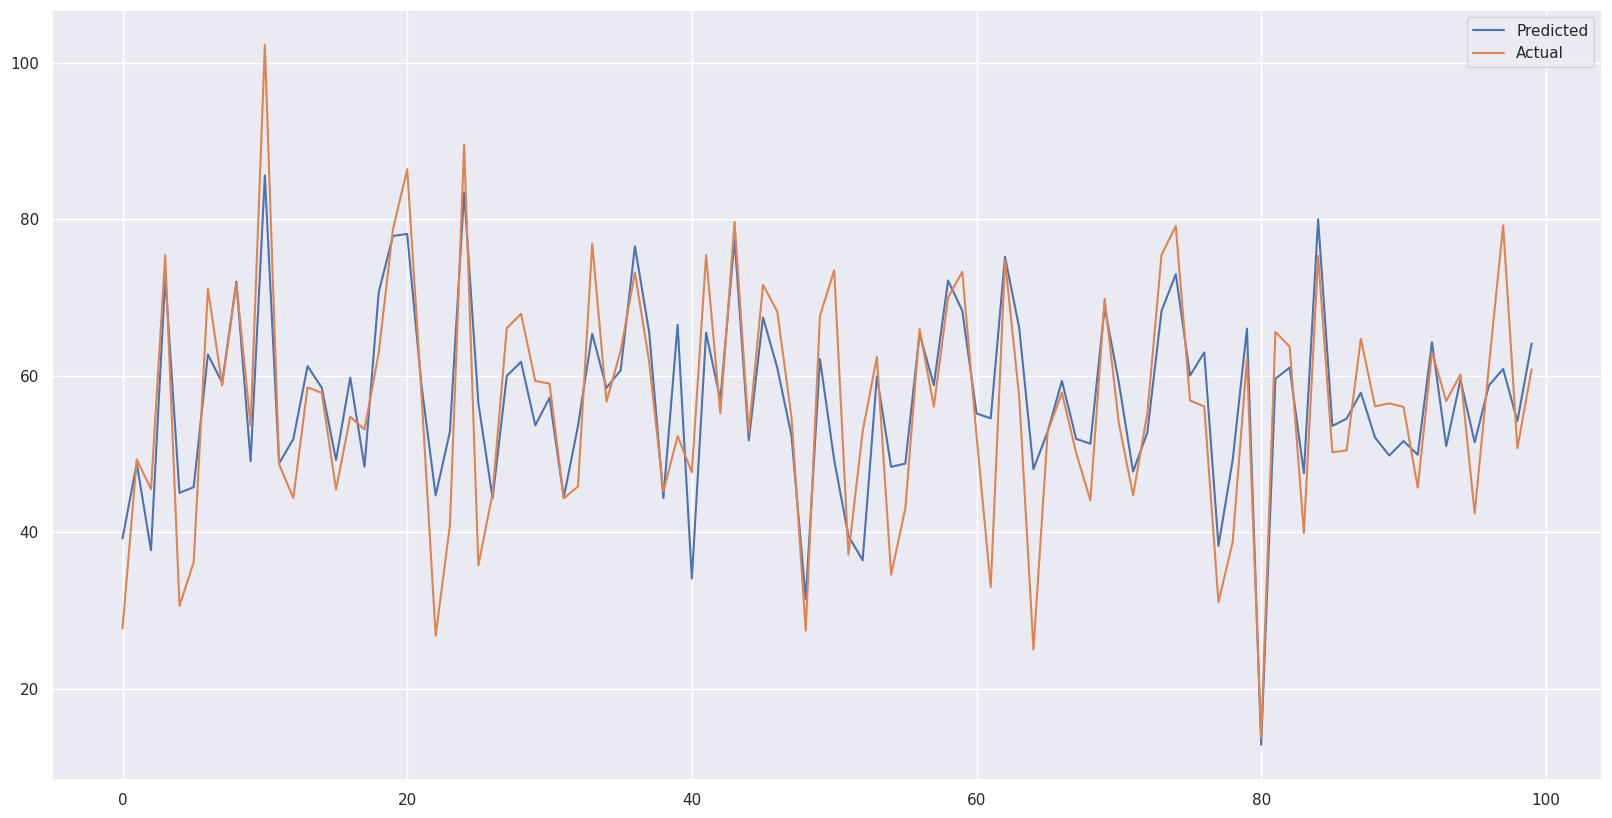

In [ ]:
from sklearn.linear_model import LinearRegression
linear_model= LinearRegression()
train_linear_model(linear_model, X_train, y_train, X_test, y_test)

## lightGBM

In [ ]:
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [ ]:
lgbr=lgb.LGBMRegressor()

In [ ]:
# finding the best parameters for XGBRegressor by gridsearchcv
lgbr_para={'n_estimators': [150,200,250],'max_depth': [7,10,13]}
lgbr_grid=GridSearchCV(estimator=lgbr,param_grid=lgbr_para,cv=5,scoring='neg_mean_squared_error',verbose=5,n_jobs=-1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7345
[LightGBM] [Info] Number of data points in the train set: 26298, number of used features: 55
[LightGBM] [Info] Start training from score 57.863032

================Evalution Matrix=========================

MSE : 10.302627856118908
RMSE : 3.209770685908716
R2 : 0.9484658583478098
Adjusted R2 :  0.9481166147965258

================Evalution Matrix=========================

    =========================================================    Evalution Graph    ===================================================



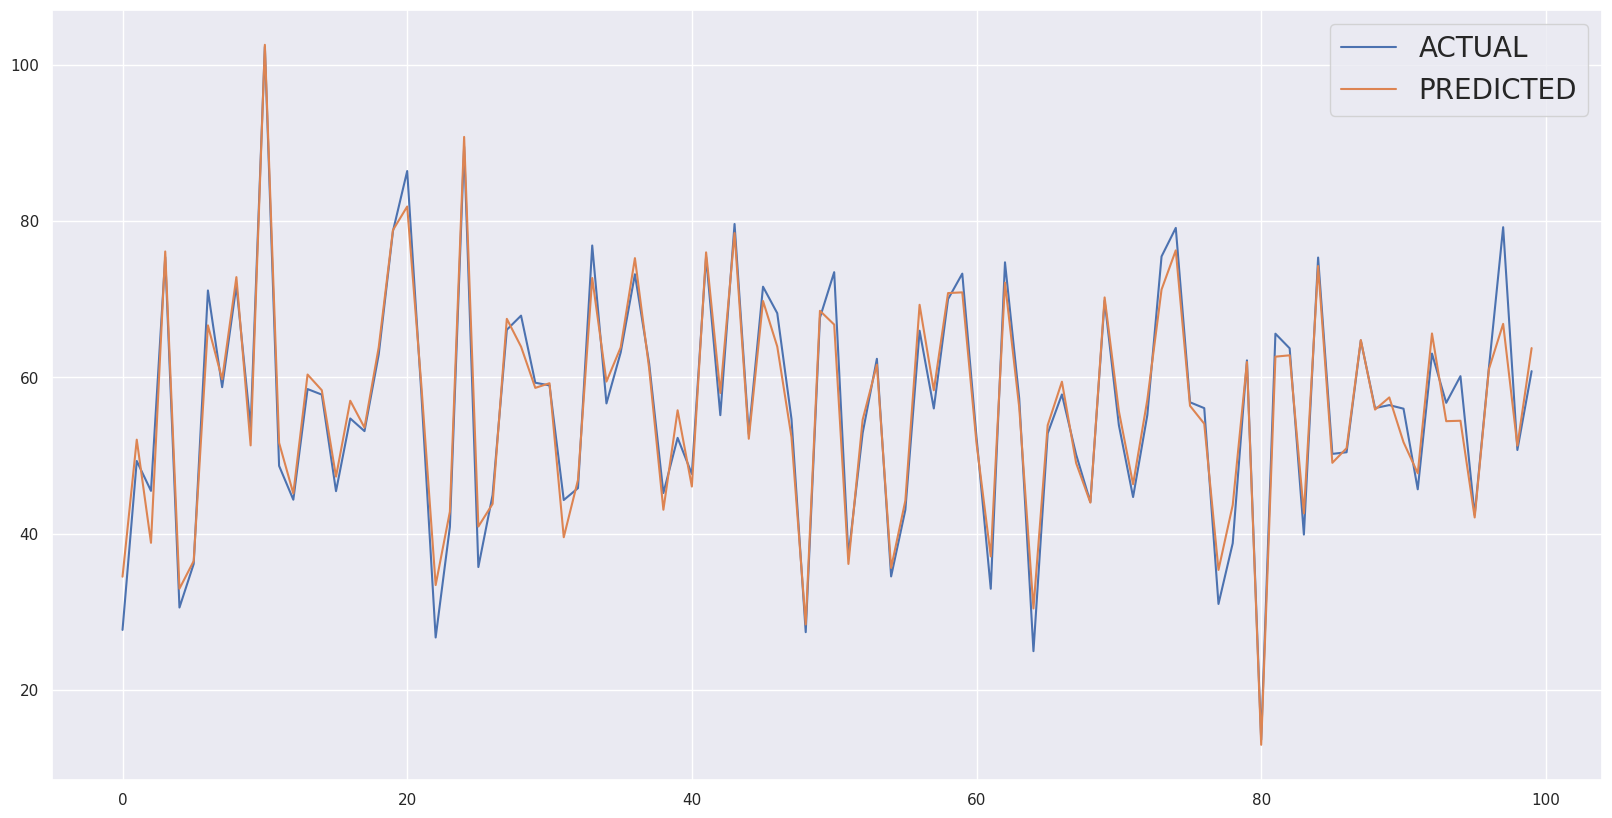

In [ ]:
#calling run_model to train,fit and evalution of catboost model
run_model(lgbr_grid,X_train,y_train,X_test,y_test)

## CatBoost

In [ ]:
#installing catboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [ ]:
#importing cat boost Regressor
from catboost import CatBoostRegressor

In [ ]:
# creating Catboost model
cb_model=CatBoostRegressor(verbose=0)


================Evalution Matrix=========================

MSE : 9.17509032940093
RMSE : 3.029041156769074
R2 : 0.9541058445175067
Adjusted R2 :  0.9537948227884155

================Evalution Matrix=========================

    =========================================================    Evalution Graph    ===================================================



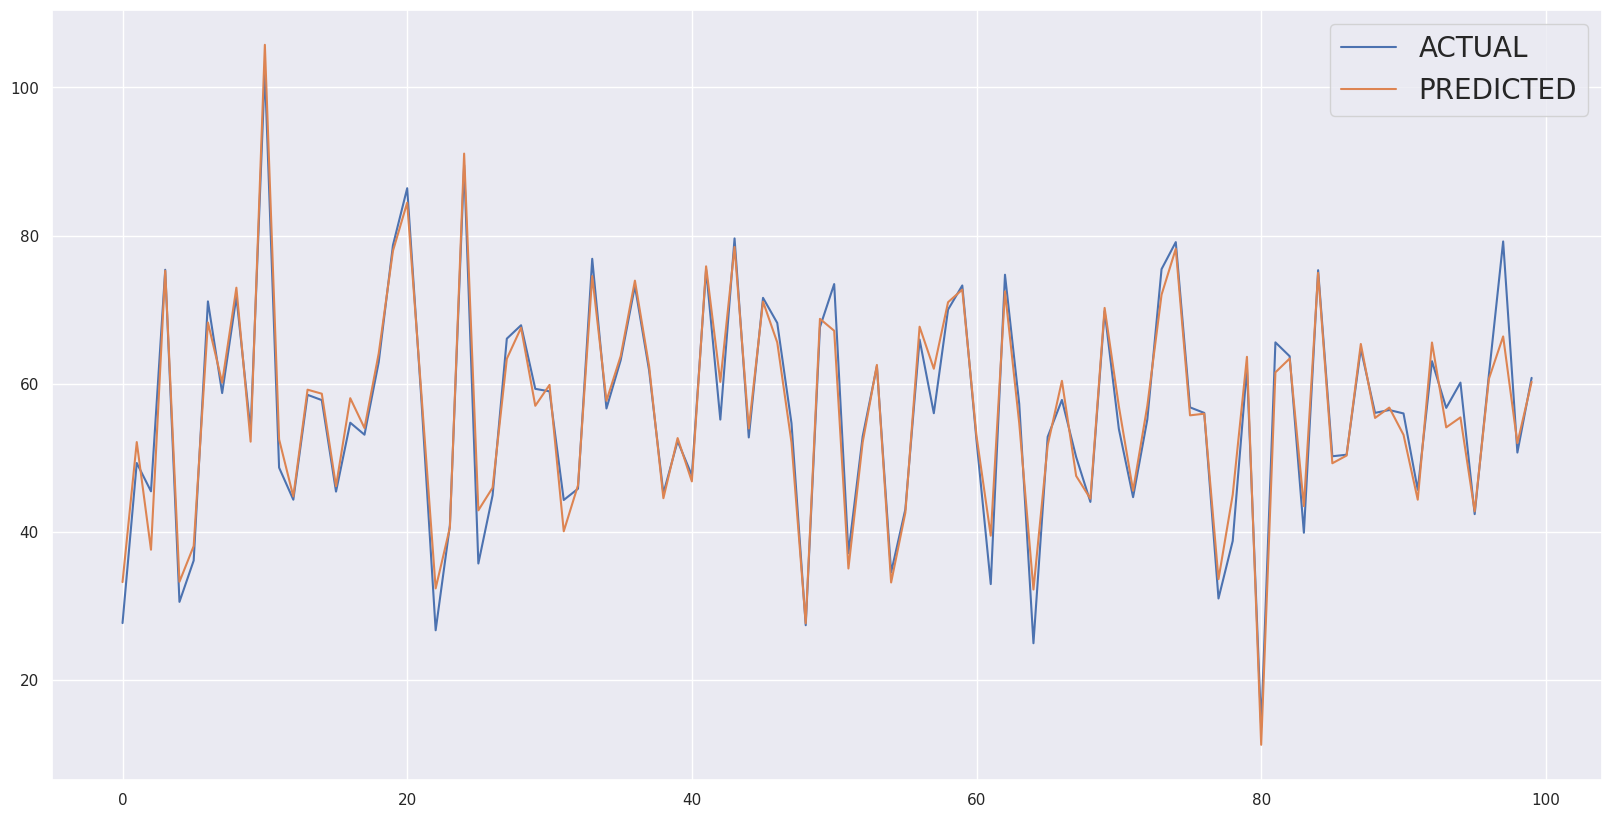

In [ ]:
#calling run_model to train,fit and evalution of catboost model
run_model(cb_model,X_train,y_train,X_test,y_test)

# **7. Combined Evaluation Matrix of All the models**

•	Based on the evaluation metrics:
o	Linear Regression performed poorly, as shown by its extremely high MSE and RMSE values and negative R².
o	CATBoost provided a much better fit with a high R² (0.948) and reasonable MSE, but it was still outperformed by LightGBM.
o	LightGBM proved to be the most accurate model, achieving the best performance across all metrics, with an R² of 0.954, an MSE of 9.17, and the lowest RMSE of 3.03. This suggests that LightGBM was able to capture the complex relationships between electricity demand, prices, and weather factors most effectively.


In [ ]:
#creating dictionary to store all the metrices
all_model_matrices={'Mean_square_error':mean_sq_error,'Root_Mean_square_error':root_mean_sq_error,'R2':r2_list,'Adjusted_R2':adj_r2_list}

In [ ]:
#list of all model made ,'Gradient_Boosting',,'CATBoost'
model_name=['Linear','CATBoost','lightGBM']

In [ ]:
#converting dictionary to dataframe fro easy visual
matrices_df=pd.DataFrame.from_dict(all_model_matrices,orient="index",columns=model_name)

In [ ]:
matrices_df

Linear   CATBoost  lightGBM
Mean_square_error       2.085660e+38  10.302628  9.175090
Root_Mean_square_error  1.444181e+19   3.209771  3.029041
R2                     -8.087217e+31   0.948466  0.954106
Adjusted_R2            -8.142023e+31   0.948117  0.953795

# SHAP

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
from sklearn.tree import export_graphviz
import shap
sns.set_style('darkgrid')

In [ ]:
for_instance=2

In [ ]:
#shape for catboost model
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(cb_model)
# obtain shap values for the first row of the test data
shap_values = explainer(X_test,check_additivity=False)
# # visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[for_instance])

In [ ]:
#shap for lightGBM model
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(lgbr_grid.best_estimator_)
# obtain shap values for the first row of the test data
shap_values = explainer(X_test,check_additivity=False)
# # visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[for_instance])

# **8.  Final Conclusion:**

The electricity price and demand forecasting project aimed to develop models that could predict future trends based on historical energy consumption and weather data. Multiple models were employed to address this multivariate time series forecasting problem, including Linear Regression, CATBoost, and LightGBM. The evaluation metrics used to compare the models were Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² (coefficient of determination). Below are the key insights based on model performance:

Linear Regression Model:

The MSE was extremely high, at
2.085
×
1
0
38
2.085×10
38
 , indicating a very poor fit for the data.
The RMSE was similarly large at
1.444
×
1
0
19
1.444×10
19
 , which suggests that the Linear model is not suitable for this dataset.
The R² value was negative (-
8.087
×
1
0
31
8.087×10
31
 ), which indicates that the model performs far worse than simply predicting the mean of the target variable. This negative value suggests that the linear model is unable to capture the underlying patterns in the data, possibly due to the complexity and non-linearity in the relationship between the features.

CATBoost Model:

The MSE was much lower at 10.30, indicating a significant improvement over the linear model.
The RMSE was 3.21, reflecting a reasonable level of error in predicting electricity prices and demand.
The R² value was 0.948, suggesting that the CATBoost model explains approximately 94.8% of the variance in the data. This indicates a good fit, as the model is able to capture most of the data’s trends and patterns.
Adjusted R² was similarly strong at 0.948, showing that even after accounting for the number of predictors, the model maintains high explanatory power.


LightGBM Model:

The MSE for LightGBM was the lowest among the models at 9.18, showing it to be the most accurate in minimizing the squared differences between actual and predicted values.
The RMSE was 3.03, slightly better than CATBoost, indicating a lower prediction error.
The R² value of 0.954 indicates that the LightGBM model explained 95.4% of the variance, outperforming the CATBoost model. This makes LightGBM the best overall model in terms of accuracy.
The Adjusted R² was 0.953, again confirming that the model performed exceptionally well, even when accounting for the number of features used in the analysis.
Final Insight:
From the comparison, it is evident that LightGBM is the best-performing model for this dataset, with the lowest error rates and the highest R² values. It outperformed both the Linear Regression and CATBoost models in predicting electricity prices and demand.

The Linear Regression model, on the other hand, was ineffective due to the complex, non-linear relationships in the data. Models like CATBoost and LightGBM, which are designed to handle non-linearity and complex feature interactions, performed much better, with LightGBM emerging as the most accurate model for this forecasting task.

The results suggest that more advanced machine learning models like LightGBM are better suited for time series forecasting in the energy domain, where multivariate factors such as weather and consumption patterns play significant roles.

LightGBM emerged as the best model for forecasting electricity demand and prices, outperforming both CATBoost and Linear Regression by a considerable margin.
The project highlighted the importance of using advanced models like gradient boosting to handle the complex and non-linear relationships present in energy consumption and price forecasting.
Accurately predicting electricity demand and prices using models like LightGBM has practical applications in energy management, such as optimizing energy production, reducing costs, and planning for periods of peak demand.